In [2]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import random
import matplotlib.pyplot as plt
%matplotlib inline

import highway_env
import pprint


In [3]:
# Environment
env = gym.make("highway-v0", render_mode='rgb_array')
env.reset()

# env = gym.make(
#   "highway-v0",
#   render_mode='rgb_array',
#   config={"lanes_count": 2}
# )

pprint.pprint(env.unwrapped.config)
num_actions = env.action_space.n
obs_shape   = env.observation_space.shape
print(f"num_actions: {num_actions}")
print(f"obs_shape: {obs_shape}")

# Q‑network factory
def create_q_model():
    return tf.keras.Sequential([
        layers.Flatten(input_shape=obs_shape),   # flatten the (5,5) → (25,)
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_actions, activation='linear'),
    ])

# def create_q_model():
#     return tf.keras.Sequential([
#         layers.Input(shape=obs_shape),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(num_actions, activation='linear')
#     ])

# Instantiate online & target nets
q_model   = create_q_model()
q_target  = create_q_model()
q_target.set_weights(q_model.get_weights())


{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}
num_actions: 5
obs_shape: (5, 5)


/Users/brandonkeung/.pyenv/versions/3.11.9/envs/RL2/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
gamma              = 0.99
batch_size         = 64
buffer             = deque(maxlen=50_000)
epsilon, eps_min   = 1.0, 0.01
eps_decay          = 0.99
# eps_decay = 0.9
target_update_freq = 1_000     # steps
num_episodes       = 500        # 1000
max_steps_per_ep   = 200

optimizer = tf.keras.optimizers.Adam(5e-4)
loss_fn   = tf.keras.losses.MeanSquaredError()


In [9]:
episode_rewards = []
step_count = 0

for ep in range(1, num_episodes+1):
    state, _ = env.reset(seed=ep)
    total_reward = 0

    for t in range(max_steps_per_ep):
        # ε-greedy
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals  = q_model.predict(state[np.newaxis], verbose=0)[0]
            action  = np.argmax(q_vals)
        # print(action)
        next_state, reward, term, trunc, _ = env.step(action)
        done = term or trunc

        # store
        buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_count += 1

        # learn
        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            S = np.array([b[0] for b in batch])
            A = np.array([b[1] for b in batch])
            R = np.array([b[2] for b in batch])
            S2 = np.array([b[3] for b in batch])
            D = np.array([b[4] for b in batch],float)

            q_next = q_target.predict(S2, verbose=0)
            q_next = q_target.predict(S2, verbose=0)
            # print("DEBUG:", q_next.shape, R.shape, D.shape)
            # print("q_next.shape:",q_next.shape)         # expect (64,5)
            # print("np.max(q_next,axis=1):", np.max(q_next,axis=1).shape)
            # print("R.shape, D.shape:", R.shape, D.shape)      # expect both (64,)

            # compute TD targets
            q_next = q_target.predict(S2, verbose=0)        # → (batch_size, 5)
            # max_q_next = np.max(q_next, axis=1)                 # → (batch_size,)
            max_q_next = np.max(q_next, axis=-1)
            
            R = R.reshape(-1)
            D = D.reshape(-1)

            y = R + (1-D)*gamma * max_q_next           # → (batch_size,)

            # q_next = q_target.predict(S2, verbose=0)
            # y = R + (1-D)*gamma*np.max(q_next,axis=1)

            # gradient step
            with tf.GradientTape() as tape:
                q_pred = q_model(S)
                q_sel  = tf.reduce_sum(q_pred * tf.one_hot(A, num_actions), axis=1)
                loss   = loss_fn(y, q_sel)
            grads = tape.gradient(loss, q_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, q_model.trainable_variables))

        # update target network
        if step_count % target_update_freq == 0:
            q_target.set_weights(q_model.get_weights())

        if done:
            break

    episode_rewards.append(total_reward)
    epsilon = max(eps_min, epsilon * eps_decay)

    if ep % 10 == 0:
        print(f"Episode {ep}/{num_episodes} — Reward: {total_reward:.1f}, ε: {epsilon:.3f}")


Episode 10/1000 — Reward: 17.7, ε: 0.904
Episode 20/1000 — Reward: 27.2, ε: 0.818
Episode 30/1000 — Reward: 5.1, ε: 0.740
Episode 40/1000 — Reward: 29.9, ε: 0.669
Episode 50/1000 — Reward: 14.3, ε: 0.605
Episode 60/1000 — Reward: 30.0, ε: 0.547
Episode 70/1000 — Reward: 15.8, ε: 0.495
Episode 80/1000 — Reward: 29.9, ε: 0.448
Episode 90/1000 — Reward: 8.1, ε: 0.405
Episode 100/1000 — Reward: 28.3, ε: 0.366
Episode 110/1000 — Reward: 27.9, ε: 0.331
Episode 120/1000 — Reward: 14.0, ε: 0.299
Episode 130/1000 — Reward: 29.5, ε: 0.271
Episode 140/1000 — Reward: 29.7, ε: 0.245
Episode 150/1000 — Reward: 30.2, ε: 0.221
Episode 160/1000 — Reward: 29.2, ε: 0.200
Episode 170/1000 — Reward: 29.1, ε: 0.181
Episode 180/1000 — Reward: 8.8, ε: 0.164
Episode 190/1000 — Reward: 30.2, ε: 0.148
Episode 200/1000 — Reward: 27.5, ε: 0.134
Episode 210/1000 — Reward: 29.0, ε: 0.121
Episode 220/1000 — Reward: 27.8, ε: 0.110
Episode 230/1000 — Reward: 29.8, ε: 0.099
Episode 240/1000 — Reward: 29.1, ε: 0.090
Epis

KeyboardInterrupt: 

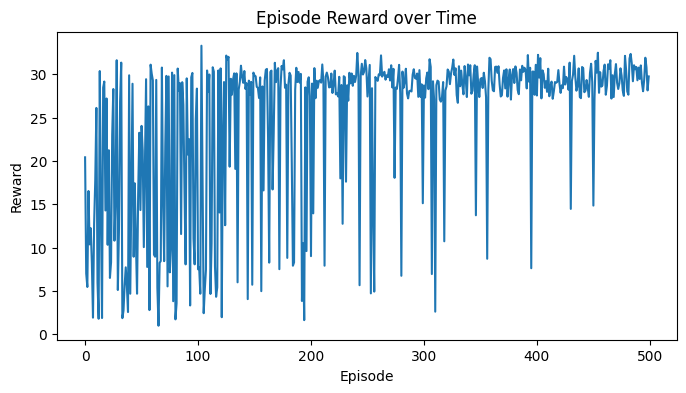

In [10]:
plt.figure(figsize=(8,4))
plt.plot(episode_rewards)
plt.title("Episode Reward over Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


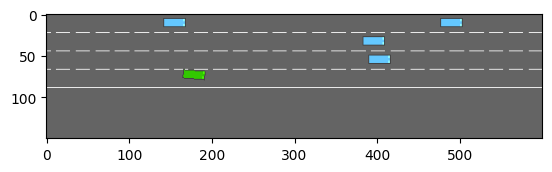

Average eval reward over 20 eps: 29.306581584465544


In [11]:
eval_rewards = []
for i in range(20):
    state, _ = env.reset(seed=100+i)
    total_r = 0
    done = False
    while not done:
        action = np.argmax(q_model.predict(state[np.newaxis], verbose=0)[0])
        state, reward, term, trunc, _ = env.step(action)
        env.render()
        done = term or trunc
        total_r += reward
    eval_rewards.append(total_r)

plt.imshow(env.render())
plt.show()

print("Average eval reward over 20 eps:", np.mean(eval_rewards))


### Without adjustments to optimizer and epsilon

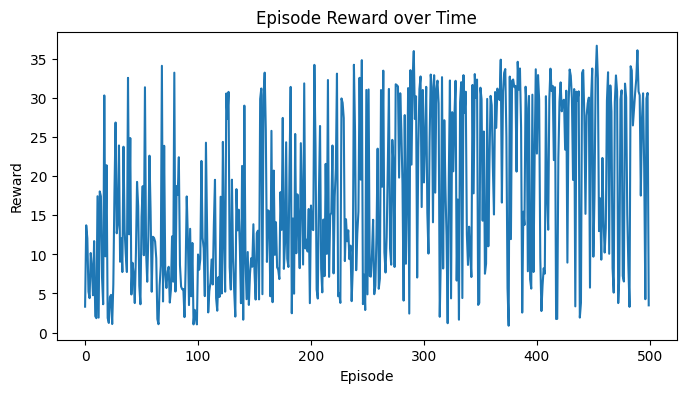

In [51]:
plt.figure(figsize=(8,4))
plt.plot(episode_rewards)
plt.title("Episode Reward over Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


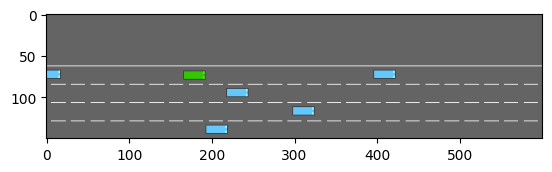

Average eval reward over 20 eps: 25.686814510756285


In [52]:
eval_rewards = []
for i in range(20):
    state, _ = env.reset(seed=100+i)
    total_r = 0
    done = False
    while not done:
        action = np.argmax(q_model.predict(state[np.newaxis], verbose=0)[0])
        state, reward, term, trunc, _ = env.step(action)
        env.render()
        done = term or trunc
        total_r += reward
    eval_rewards.append(total_r)

plt.imshow(env.render())
plt.show()

print("Average eval reward over 20 eps:", np.mean(eval_rewards))


# Aggressive

In [4]:
# Environment
# env = gym.make("highway-v0", render_mode='rgb_array')
# env.reset()

env = gym.make(
    "highway-v0",
    render_mode='rgb_array',
    config={'reward_speed_range': [25, 30],
            'high_speed_reward': 0.4,}
)
env.reset()

pprint.pprint(env.unwrapped.config)
num_actions = env.action_space.n
obs_shape   = env.observation_space.shape
print(f"num_actions: {num_actions}")
print(f"obs_shape: {obs_shape}")

# Q‑network factory
def create_q_model():
    return tf.keras.Sequential([
        layers.Flatten(input_shape=obs_shape),   # flatten the (5,5) → (25,)
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_actions, activation='linear'),
    ])

# def create_q_model():
#     return tf.keras.Sequential([
#         layers.Input(shape=obs_shape),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(num_actions, activation='linear')
#     ])

# Instantiate online & target nets
q_model   = create_q_model()
q_target  = create_q_model()
q_target.set_weights(q_model.get_weights())


{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.9,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [25, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}
num_actions: 5
obs_shape: (5, 5)


/Users/brandonkeung/.pyenv/versions/3.11.9/envs/RL2/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
gamma              = 0.99
batch_size         = 64
buffer             = deque(maxlen=50_000)
epsilon, eps_min   = 1.0, 0.01
eps_decay          = 0.995
# eps_decay = 0.9
target_update_freq = 1_000     # steps
num_episodes       = 1000    # 115 min for 1000   # 2000
max_steps_per_ep   = 200

optimizer = tf.keras.optimizers.Adam(5e-4)
loss_fn   = tf.keras.losses.MeanSquaredError()


In [13]:
aggressive_episode_rewards = []
step_count = 0

for ep in range(1, num_episodes+1):
    state, _ = env.reset(seed=ep)
    total_reward = 0

    for t in range(max_steps_per_ep):
        # ε-greedy
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals  = q_model.predict(state[np.newaxis], verbose=0)[0]
            action  = np.argmax(q_vals)
        # print(action)
        next_state, reward, term, trunc, _ = env.step(action)
        done = term or trunc

        # store
        buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_count += 1

        # learn
        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            S = np.array([b[0] for b in batch])
            A = np.array([b[1] for b in batch])
            R = np.array([b[2] for b in batch])
            S2 = np.array([b[3] for b in batch])
            D = np.array([b[4] for b in batch],float)

            q_next = q_target.predict(S2, verbose=0)
            q_next = q_target.predict(S2, verbose=0)
            # print("DEBUG:", q_next.shape, R.shape, D.shape)
            # print("q_next.shape:",q_next.shape)         # expect (64,5)
            # print("np.max(q_next,axis=1):", np.max(q_next,axis=1).shape)
            # print("R.shape, D.shape:", R.shape, D.shape)      # expect both (64,)

            # compute TD targets
            q_next = q_target.predict(S2, verbose=0)        # → (batch_size, 5)
            # max_q_next = np.max(q_next, axis=1)                 # → (batch_size,)
            max_q_next = np.max(q_next, axis=-1)
            
            R = R.reshape(-1)
            D = D.reshape(-1)

            y = R + (1-D)*gamma * max_q_next           # → (batch_size,)

            # q_next = q_target.predict(S2, verbose=0)
            # y = R + (1-D)*gamma*np.max(q_next,axis=1)

            # gradient step
            with tf.GradientTape() as tape:
                q_pred = q_model(S)
                q_sel  = tf.reduce_sum(q_pred * tf.one_hot(A, num_actions), axis=1)
                loss   = loss_fn(y, q_sel)
            grads = tape.gradient(loss, q_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, q_model.trainable_variables))

        # update target network
        if step_count % target_update_freq == 0:
            q_target.set_weights(q_model.get_weights())

        if done:
            break

    aggressive_episode_rewards.append(total_reward)
    epsilon = max(eps_min, epsilon * eps_decay)

    if ep % 10 == 0:
        print(f"Episode {ep}/{num_episodes} — Reward: {total_reward:.1f}, ε: {epsilon:.3f}")


Episode 10/2000 — Reward: 20.5, ε: 0.951
Episode 20/2000 — Reward: 1.1, ε: 0.905
Episode 30/2000 — Reward: 9.2, ε: 0.860
Episode 40/2000 — Reward: 3.6, ε: 0.818
Episode 50/2000 — Reward: 7.7, ε: 0.778
Episode 60/2000 — Reward: 5.4, ε: 0.740
Episode 70/2000 — Reward: 21.2, ε: 0.704
Episode 80/2000 — Reward: 1.4, ε: 0.670
Episode 90/2000 — Reward: 9.3, ε: 0.637
Episode 100/2000 — Reward: 1.1, ε: 0.606
Episode 110/2000 — Reward: 7.8, ε: 0.576
Episode 120/2000 — Reward: 10.8, ε: 0.548
Episode 130/2000 — Reward: 14.4, ε: 0.521
Episode 140/2000 — Reward: 18.2, ε: 0.496
Episode 150/2000 — Reward: 26.1, ε: 0.471
Episode 160/2000 — Reward: 1.8, ε: 0.448
Episode 170/2000 — Reward: 22.0, ε: 0.427
Episode 180/2000 — Reward: 1.8, ε: 0.406
Episode 190/2000 — Reward: 21.1, ε: 0.386
Episode 200/2000 — Reward: 24.6, ε: 0.367
Episode 210/2000 — Reward: 19.3, ε: 0.349
Episode 220/2000 — Reward: 15.0, ε: 0.332
Episode 230/2000 — Reward: 7.7, ε: 0.316
Episode 240/2000 — Reward: 23.6, ε: 0.300
Episode 250/2

KeyboardInterrupt: 

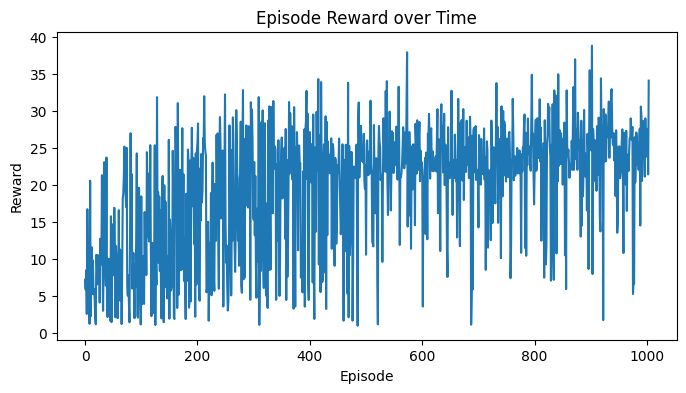

In [14]:
plt.figure(figsize=(8,4))
plt.plot(aggressive_episode_rewards)
plt.title("Episode Reward over Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


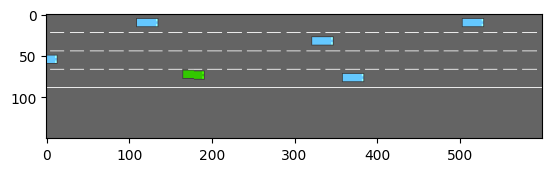

Average eval reward over 20 eps: 24.667600369511987


In [15]:
aggressive_eval_rewards = []
for i in range(20):
    state, _ = env.reset(seed=100+i)
    total_r = 0
    done = False
    while not done:
        action = np.argmax(q_model.predict(state[np.newaxis], verbose=0)[0])
        state, reward, term, trunc, _ = env.step(action)
        env.render()
        done = term or trunc
        total_r += reward
    aggressive_eval_rewards.append(total_r)

plt.imshow(env.render())
plt.show()

print("Average eval reward over 20 eps:", np.mean(aggressive_eval_rewards))


# Safe (slow)

In [16]:
# Environment
# env = gym.make("highway-v0", render_mode='rgb_array')
# env.reset()

env = gym.make(
    "highway-v0",
    render_mode='rgb_array',
    config={'reward_speed_range': [0, 20]}
)
env.reset()

pprint.pprint(env.unwrapped.config)
num_actions = env.action_space.n
obs_shape   = env.observation_space.shape
print(f"num_actions: {num_actions}")
print(f"obs_shape: {obs_shape}")

# Q‑network factory
def create_q_model():
    return tf.keras.Sequential([
        layers.Flatten(input_shape=obs_shape),   # flatten the (5,5) → (25,)
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_actions, activation='linear'),
    ])

# def create_q_model():
#     return tf.keras.Sequential([
#         layers.Input(shape=obs_shape),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(num_actions, activation='linear')
#     ])

# Instantiate online & target nets
q_model   = create_q_model()
q_target  = create_q_model()
q_target.set_weights(q_model.get_weights())


{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [0, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}
num_actions: 5
obs_shape: (5, 5)


/Users/brandonkeung/.pyenv/versions/3.11.9/envs/RL2/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
gamma              = 0.99
batch_size         = 64
buffer             = deque(maxlen=50_000)
epsilon, eps_min   = 1.0, 0.01
eps_decay          = 0.99
# eps_decay = 0.9
target_update_freq = 1_000     # steps
num_episodes       = 1000    # 2000
max_steps_per_ep   = 200

optimizer = tf.keras.optimizers.Adam(5e-4)
loss_fn   = tf.keras.losses.MeanSquaredError()

In [ ]:
safe_episode_rewards = []
step_count = 0

for ep in range(1, num_episodes+1):
    state, _ = env.reset(seed=ep)
    total_reward = 0

    for t in range(max_steps_per_ep):
        # ε-greedy
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals  = q_model.predict(state[np.newaxis], verbose=0)[0]
            action  = np.argmax(q_vals)
        # print(action)
        next_state, reward, term, trunc, _ = env.step(action)
        done = term or trunc

        # store
        buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_count += 1

        # learn
        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            S = np.array([b[0] for b in batch])
            A = np.array([b[1] for b in batch])
            R = np.array([b[2] for b in batch])
            S2 = np.array([b[3] for b in batch])
            D = np.array([b[4] for b in batch],float)

            q_next = q_target.predict(S2, verbose=0)
            q_next = q_target.predict(S2, verbose=0)
            # print("DEBUG:", q_next.shape, R.shape, D.shape)
            # print("q_next.shape:",q_next.shape)         # expect (64,5)
            # print("np.max(q_next,axis=1):", np.max(q_next,axis=1).shape)
            # print("R.shape, D.shape:", R.shape, D.shape)      # expect both (64,)

            # compute TD targets
            q_next = q_target.predict(S2, verbose=0)        # → (batch_size, 5)
            # max_q_next = np.max(q_next, axis=1)                 # → (batch_size,)
            max_q_next = np.max(q_next, axis=-1)
            
            R = R.reshape(-1)
            D = D.reshape(-1)

            y = R + (1-D)*gamma * max_q_next           # → (batch_size,)

            # q_next = q_target.predict(S2, verbose=0)
            # y = R + (1-D)*gamma*np.max(q_next,axis=1)

            # gradient step
            with tf.GradientTape() as tape:
                q_pred = q_model(S)
                q_sel  = tf.reduce_sum(q_pred * tf.one_hot(A, num_actions), axis=1)
                loss   = loss_fn(y, q_sel)
            grads = tape.gradient(loss, q_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, q_model.trainable_variables))

        # update target network
        if step_count % target_update_freq == 0:
            q_target.set_weights(q_model.get_weights())

        if done:
            break

    safe_episode_rewards.append(total_reward)
    epsilon = max(eps_min, epsilon * eps_decay)

    if ep % 10 == 0:
        print(f"Episode {ep}/{num_episodes} — Reward: {total_reward:.1f}, ε: {epsilon:.3f}")


Episode 10/1000 — Reward: 9.2, ε: 0.851
Episode 20/1000 — Reward: 2.0, ε: 0.770
Episode 30/1000 — Reward: 1.9, ε: 0.696
Episode 40/1000 — Reward: 2.2, ε: 0.630
Episode 50/1000 — Reward: 20.5, ε: 0.570
Episode 60/1000 — Reward: 32.4, ε: 0.515
Episode 70/1000 — Reward: 6.8, ε: 0.466
Episode 80/1000 — Reward: 15.6, ε: 0.421
Episode 90/1000 — Reward: 13.1, ε: 0.381
Episode 100/1000 — Reward: 15.2, ε: 0.345
Episode 110/1000 — Reward: 35.0, ε: 0.312
Episode 120/1000 — Reward: 9.8, ε: 0.282
Episode 130/1000 — Reward: 28.4, ε: 0.255
Episode 140/1000 — Reward: 36.5, ε: 0.231
Episode 150/1000 — Reward: 13.8, ε: 0.208
Episode 160/1000 — Reward: 34.4, ε: 0.189
Episode 170/1000 — Reward: 13.1, ε: 0.171
Episode 180/1000 — Reward: 34.4, ε: 0.154
Episode 190/1000 — Reward: 35.2, ε: 0.139
Episode 200/1000 — Reward: 9.6, ε: 0.126
Episode 210/1000 — Reward: 34.6, ε: 0.114
Episode 220/1000 — Reward: 34.8, ε: 0.103
Episode 230/1000 — Reward: 12.6, ε: 0.093
Episode 240/1000 — Reward: 35.1, ε: 0.084
Episode 

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(safe_episode_rewards)
plt.title("Episode Reward over Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

safe_eval_rewards = []
for i in range(20):
    state, _ = env.reset(seed=100+i)
    total_r = 0
    done = False
    while not done:
        action = np.argmax(q_model.predict(state[np.newaxis], verbose=0)[0])
        state, reward, term, trunc, _ = env.step(action)
        env.render()
        done = term or trunc
        total_r += reward
    safe_eval_rewards.append(total_r)

plt.imshow(env.render())
plt.show()

print("Average eval reward over 20 eps:", np.mean(safe_eval_rewards))
